# Time Domain Tutorial #2
## State Space Oscillator Networks: Common Oscillator Models

NESS 2023

Emily Stephen, with Wan-Chi Hsin (COM theory and Matlab Code) and Eric Denovellis (Initial COM Python Code)


The Common Oscillator Model<sup>1</sup> has a small number of latent SSOs that drive the activity at all electrodes. 

In this tutorial, we will simulate the model and then fit the observation matrix, $B$, that captures the functional connectivity structure in the data. To do so, we will use the `python` branch of the `common_oscillator_model` package.

[1] Hsin, W. C., Eden, U. T., & Stephen, E. P. (2022, October). Switching Functional Network Models of Oscillatory Brain Dynamics. In 2022 56th Asilomar Conference on Signals, Systems, and Computers (pp. 607-612). IEEE. [10.1109/IEEECONF56349.2022.10052077](https://doi.org/10.1109/IEEECONF56349.2022.10052077)

Here is a schematic of the model: 
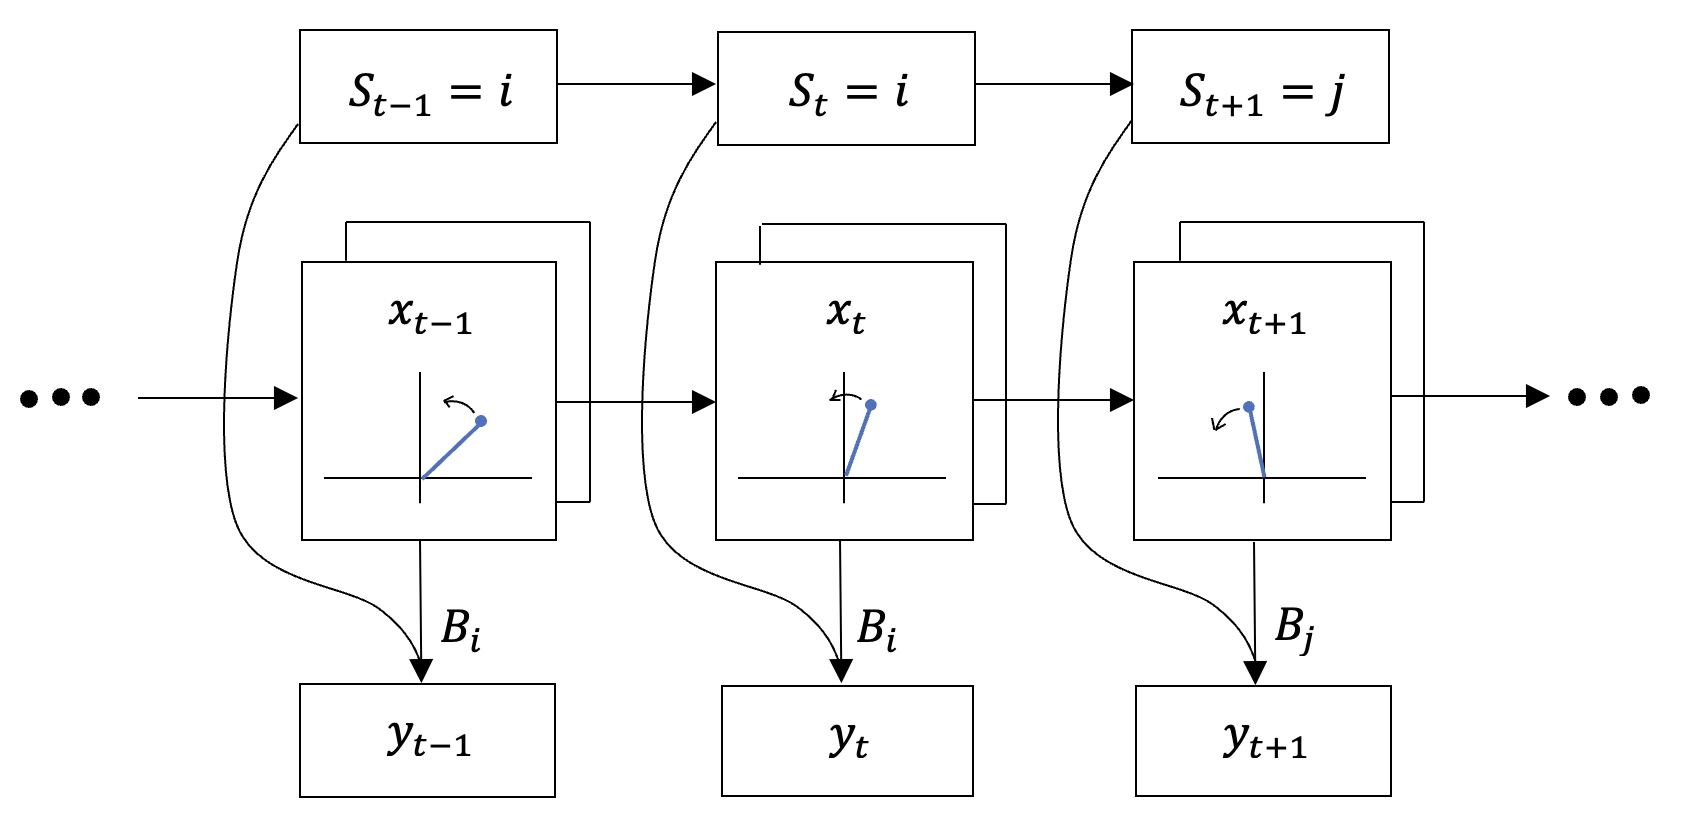


Let $K$ be the number of oscillators, $N$ be the number of electrodes, $M$ be the number of discrete states, and $T$ be the number of time points.

The model is made up of three sequences:
- $S_t$ is the (scalar) discrete hidden state sequence 
- $x_t$ is the $2K\times 1$ continuous hidden state sequence (each oscillator has two components, representing a real and 
- $y_t$ is the $N\times 1$ observation sequence

### Discrete Hidden State
The discrete hidden state dynamics are determined by:
$$P(S_t=j|S_{t-1}=i) = Z_{ij}$$

- $Z$ is the $M\times M$ matrix of discrete state transition probabilities
imaginary part)

### Continuous Hidden State
The dynamics of the oscillators are determined by:
$$(x_t|x_{t-1}) \sim N(A x_{t-1},\Sigma)$$

Which are translated into the dynamical model for $x_t$ via:
- $A$ is the the $2K\times 2K$ transition matrix for the continuous hidden state. It has block diagonal structure, capturing each oscillator
- $\Sigma=\sigma I$ is the state noise covariance (in these simulations all of the oscillators have the same variance, but the model can acount for different variances)

$$A = \begin{pmatrix}
A_1 & 0 & \cdots & 0 \\
0 & A_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & A_K 
	\end{pmatrix} 
$$

$$A_k = a_k \begin{pmatrix}
\text{cos}(\omega_k) & -\text{sin}(\omega_k) \\
\text{sin}(\omega_k) & \text{cos}(\omega_k),
	\end{pmatrix}$$ 

$$\omega_k = 2\pi f_k/F_s$$

- $f_k$ is the frequency (in Hz) of oscillator $k$
- $a_k$ is the damping coefficient of oscillator $k$
- $F_s$ is the sampling frequency (in Hz)



### Observations
The observations are related to the hidden states via the matrices $B_j$ (there are $M$ of them, one for each hidden state):
$$(y_t|x_t,S_t=j) \sim N(B_j x_t,R)$$

- $B_j$ is the $N\times 2N$ observation matrix associated with the hidden state $j$
- $R$ is the $N\times N$ observation noise covariance

\begin{equation*}
    B_j = 
        \begin{pmatrix}
            b_{j,\text{Re}}^{1,1} & b_{j,\text{Im}}^{1,1} & \cdots & b_{j,\text{Re}}^{1,K} & b_{j,\text{Im}}^{1,K} \\
            \vdots & \vdots & \ddots & \vdots & \vdots \\
            b_{j,\text{Re}}^{N,1} & b_{j,\text{Im}}^{K,1} & \cdots & b_{j,\text{Re}}^{N,K} & b_{j,\text{Im}}^{N,K}
        \end{pmatrix}
\end{equation*}




The amplitude and phase of the relationship between each electrode $n$ and each hidden oscillator $k$ during state $j$ is a function of the relevant entries of the $B$ matrix: 
\begin{equation*}
    \text{amplitude} = \sqrt{(b_{j,\text{Re}}^{n,k})^2 + (b_{j,\text{Im}}^{n,k})^2}\\
    \text{phase} = \left|\text{atan2}(b_{j,\text{Im}}^{n_1,k},b_{j,\text{Re}}^{n_1,k}) - \text{atan2}(b_{j,\text{Im}}^{n_2,k},b_{j,\text{Re}}^{n_2,k})\right|
\end{equation*}
    
    
    

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity

# From Eden-Kramer-Lab/common_oscillator_models (python branch)
from core_functions.simulated_data import simdata_settings, simulate
from core_functions.core import em_B, get_theoretical_psd_COM, B_mag_phase

## Simulation

In [2]:
# Simulate Model
T = 30000
blnSimS = False

fs, K, N, M, osc_freqs, rhos, var_state_nois, var_obs_noi, A, Q, R, Btrue, Z, X0, S0 = simdata_settings()

ta = np.arange(T)/fs
x_dim = K*2

if blnSimS:
    S=None
else:     
    S = np.zeros(T,dtype=int)
    S[ta>80]=1
    S[ta>200]=2

y, S, x = simulate(A, Btrue, Q, R, Z, X0, S0, T, s=S)


(100.0, 105.0)

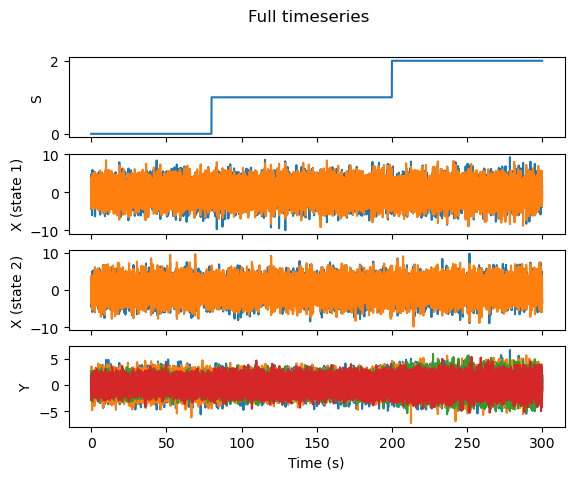

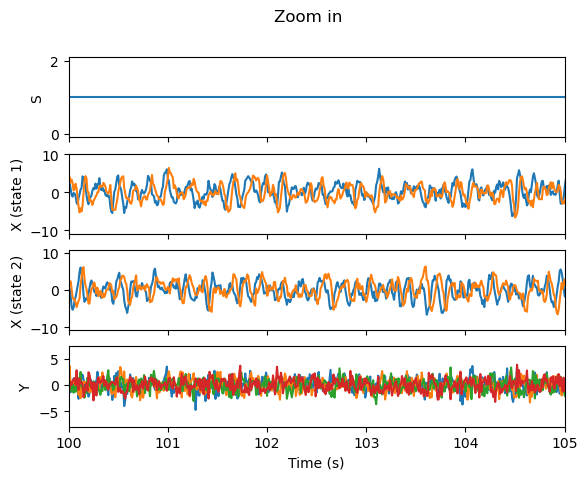

In [3]:
# Plot the simulated data

[fig,axs] = plt.subplots(2+K,1,sharex=True)
axs[0].plot(ta, S)
axs[0].set_ylabel('S')
for i in range(K):
    axs[1+i].plot(ta, x[:,2*i:2*i+2])
    axs[1+i].set_ylabel(f'X (state {i+1})')
axs[K+1].plot(ta, y)
axs[K+1].set_ylabel('Y')
axs[K+1].set_xlabel('Time (s)')
fig.suptitle('Full timeseries')

[fig,axs] = plt.subplots(2+K,1,sharex=True)
axs[0].plot(ta, S)
axs[0].set_ylabel('S')
for i in range(K):
    axs[1+i].plot(ta, x[:,2*i:2*i+2])
    axs[1+i].set_ylabel(f'X (state {i+1})')
axs[K+1].plot(ta, y)
axs[K+1].set_ylabel('Y')
axs[K+1].set_xlabel('Time (s)')
fig.suptitle('Zoom in')
axs[0].set_xlim([100,105])


## Fit B

(this cell will take a while to run)

In [4]:
# Pretend we don't know B and fit it
tol = 1e-3 # Tolerance
max_iter = 50 # Max iterations

B0 = np.random.uniform(0,0.1,size=[N,x_dim,M])

mle_B, X_RTS, SW, Q_func, itr = em_B(y, tol, max_iter, A, B0, Q, R, Z, X0)

iter: 0, Q-function: -154523.93074879423
iter: 1, Q-function: -138765.3810127928
iter: 2, Q-function: -133020.83586455608
iter: 3, Q-function: -128178.76531064886
iter: 4, Q-function: -125492.27608643135
iter: 5, Q-function: -123972.54001578428
iter: 6, Q-function: -122987.28596511662
iter: 7, Q-function: -122309.75706043045
iter: 8, Q-function: -121827.82333650664
iter: 9, Q-function: -121476.7061165172
iter: 10, Q-function: -121215.97546829718
iter: 11, Q-function: -121019.19634778475
iter: 12, Q-function: -120868.53058111356


## Plot Results

Text(0.5, 0, 'Time (s)')

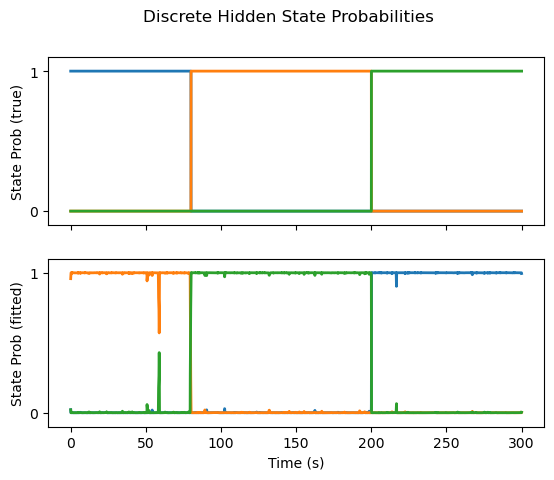

In [5]:
# plot discrete hidden state probabilities

SW_true = np.vstack([S==i for i in range(M)]).T

[fig, axs] = plt.subplots(2,1,sharex=True,sharey=True)
axs[0].plot(ta,SW_true[:,:],linewidth=2)
axs[0].set_ylabel('State Prob (true)')
axs[0].set_yticks([0, 1])
axs[0].set_ylim([-0.1, 1.1])
axs[1].plot(ta,SW[:,:,itr],linewidth=2)
axs[1].set_ylabel('State Prob (fitted)')
axs[1].set_yticks([0, 1])
axs[1].set_ylim([-0.1, 1.1])
fig.suptitle('Discrete Hidden State Probabilities')
axs[-1].set_xlabel('Time (s)')

In [6]:
# Check B
np.set_printoptions(precision=2,suppress=True)
for m in range(M):
    print(f'True B_{m}: \n{Btrue[:,:,m]}')
    print(f'Fitted B_{m}: \n{mle_B[:,:,m,itr]}')


True B_0: 
[[0.4 0.  0.  0. ]
 [0.  0.  0.4 0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
Fitted B_0: 
[[ 0.19  0.16  0.11  0.39]
 [-0.19 -0.16 -0.11 -0.39]
 [ 0.19  0.16  0.11  0.38]
 [-0.19  0.28  0.21 -0.06]]
True B_1: 
[[ 0.3   0.    0.    0.  ]
 [ 0.    0.3   0.    0.  ]
 [ 0.    0.    0.25  0.  ]
 [ 0.    0.    0.   -0.25]]
Fitted B_1: 
[[ 0.09  0.32  0.13 -0.14]
 [ 0.18  0.04  0.11  0.34]
 [-0.01 -0.    0.01 -0.01]
 [ 0.   -0.   -0.02  0.  ]]
True B_2: 
[[ 0.5  0.   0.   0. ]
 [-0.5  0.   0.   0. ]
 [ 0.5  0.   0.   0. ]
 [ 0.   0.   0.4  0. ]]
Fitted B_2: 
[[ 0.09  0.08  0.27 -0.06]
 [-0.06  0.09  0.06  0.27]
 [ 0.03  0.21 -0.09 -0.04]
 [ 0.22 -0.04 -0.04  0.09]]


Text(0, 0.5, 'Fitted')

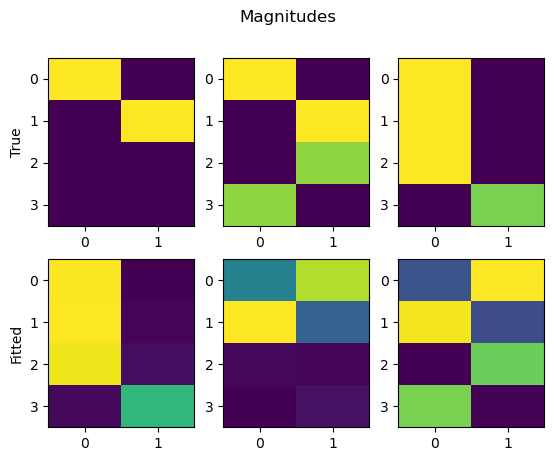

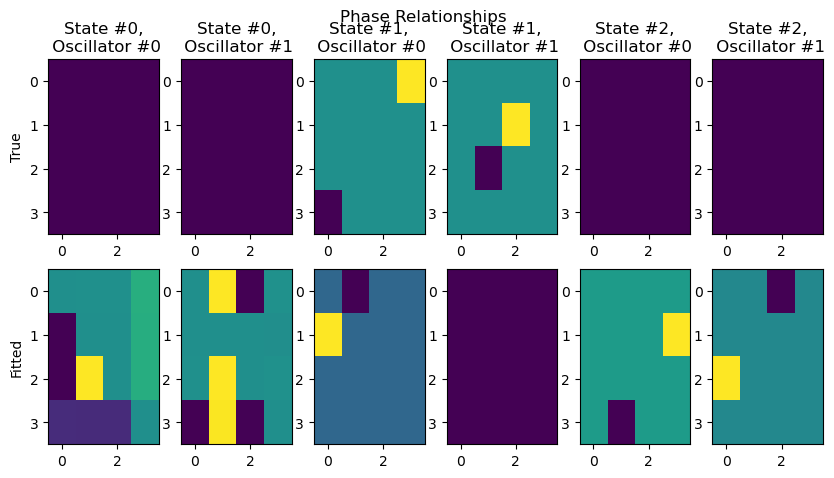

In [7]:
# Plot B

# Plot Magnitudes of B
mag_true, phase_true = B_mag_phase(Btrue)
mag_fit, phase_fit = B_mag_phase(mle_B[:,:,:,itr])

# plot magnitudes
[fig,axs] = plt.subplots(2,M)
for m in range(M):    
    axs[0,m].imshow(mag_true[:,:,m],aspect='auto')
    axs[1,m].imshow(mag_fit[:,:,m],aspect='auto')
axs[1,0].set_ylabel('Fitted')
axs[0,0].set_ylabel('True')
fig.suptitle('Magnitudes')

    
# plot phase relationships
[fig,axs] = plt.subplots(2,M*K,figsize=[10,5])
for m in range(M):    
    for i in range(K):
        axs[0,K*m+i].imshow(phase_true[:,:,i,m],aspect='auto')
        axs[1,K*m+i].imshow(phase_fit[:,:,i,m],aspect='auto')
        axs[0,K*m+i].set_title(f'State #{m},\n Oscillator #{i}')
fig.suptitle('Phase Relationships')
axs[0,0].set_ylabel('True')
axs[1,0].set_ylabel('Fitted')
   



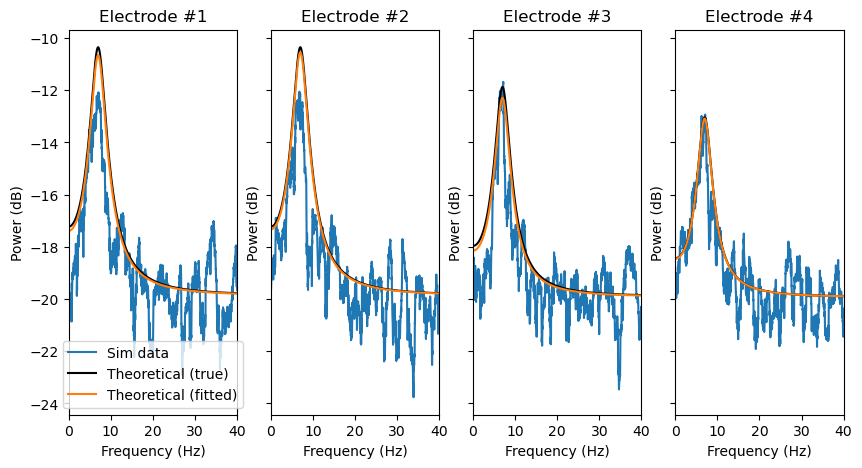

In [8]:
# plot empirical and theoretical spectra

TW=3000
ntapers = 20

m = Multitaper(y,
                sampling_frequency=fs,
                time_halfbandwidth_product=TW,
                n_tapers=ntapers,
                start_time=ta[0])
c = Connectivity(fourier_coefficients=m.fft(),
                frequencies=m.frequencies,
                time=m.time)

Stheo, Stheo_per_state = get_theoretical_psd_COM(c.frequencies,
                                                fs,
                                                osc_freqs,
                                                rhos,
                                                var_state_nois,
                                                var_obs_noi,
                                                Btrue,
                                                S)

Stheo_fit, Stheo_per_state_fit = get_theoretical_psd_COM(c.frequencies,
                                                fs,
                                                osc_freqs,
                                                rhos,
                                                var_state_nois,
                                                var_obs_noi,
                                                mle_B[:,:,:,itr],
                                                SW[:,:,itr])

[fig, axs] = plt.subplots(1,N,sharex=True,sharey=True,figsize=[10,5])
for i in range(N):
    axs[i].plot(c.frequencies, 10*np.log10(c.power().squeeze()[:,i]),label='Sim data')
    axs[i].plot(c.frequencies,10*np.log10(Stheo[:,i]),color='k',label='Theoretical (true)')
    axs[i].plot(c.frequencies,10*np.log10(Stheo_fit[:,i]),label='Theoretical (fitted)')
    axs[i].set_title(f'Electrode #{i+1}')
    axs[i].set_ylabel('Power (dB)')
    axs[i].set_xlabel('Frequency (Hz)')
axs[0].set_xlim(0,40)
axs[0].legend(loc='lower center')
